In [1]:
%matplotlib inline


# Calculating a module's IV curves

Examples of modeling IV curves using a single-diode circuit equivalent model.


Calculating a module IV curve for certain operating conditions is a two-step
process.  Multiple methods exist for both parts of the process.  Here we use
the De Soto model [1]_ to calculate the electrical parameters for an IV
curve at a certain irradiance and temperature using the module's
base characteristics at reference conditions.  Those parameters are then used
to calculate the module's IV curve by solving the single-diode equation using
the Lambert W method.

The single-diode equation is a circuit-equivalent model of a PV
cell and has five electrical parameters that depend on the operating
conditions.  For more details on the single-diode equation and the five
parameters, see the `PVPMC single diode page
<https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/>`_.

## References
 .. [1] W. De Soto et al., "Improvement and validation of a model for
    photovoltaic array performance", Solar Energy, vol 80, pp. 78-88, 2006.

## Calculating IV Curves
This example uses :py:meth:`pvlib.pvsystem.calcparams_desoto` to calculate
the 5 electrical parameters needed to solve the single-diode equation.
:py:meth:`pvlib.pvsystem.singlediode` is then used to generate the IV curves.



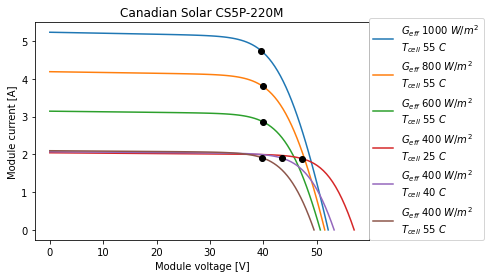

       i_sc       v_oc      i_mp       v_mp        p_mp
0  5.235561  52.129782  4.742078  39.617325  187.868460
1  4.190781  51.483032  3.805385  39.871330  151.725745
2  3.144837  50.649227  2.862258  39.952853  114.355370
3  2.043319  56.987478  1.886511  47.285357   89.204359
4  2.070523  53.238566  1.900933  43.492748   82.676788
5  2.097727  49.474043  1.911758  39.742278   75.977636


C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


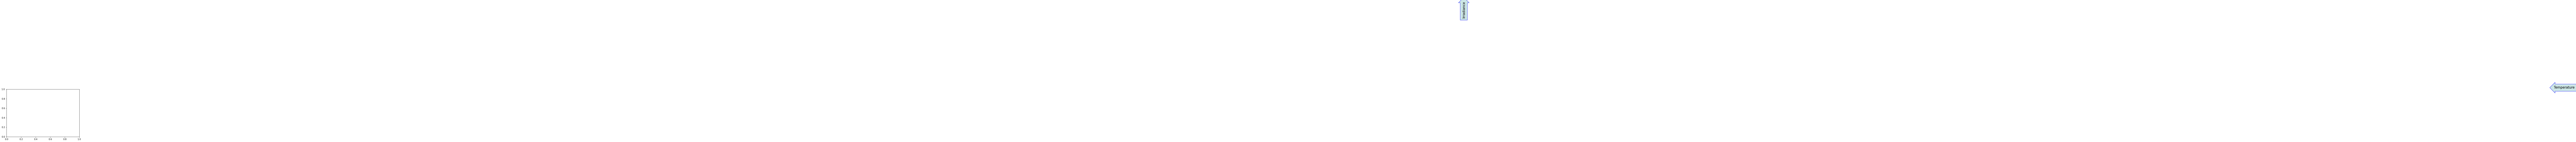

In [2]:
from pvlib import pvsystem
import pandas as pd
import matplotlib.pyplot as plt

# Example module parameters for the Canadian Solar CS5P-220M:
parameters = {
    'Name': 'Canadian Solar CS5P-220M',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 42.4,
    'A_c': 1.7,
    'N_s': 96,
    'I_sc_ref': 5.1,
    'V_oc_ref': 59.4,
    'I_mp_ref': 4.69,
    'V_mp_ref': 46.9,
    'alpha_sc': 0.004539,
    'beta_oc': -0.22216,
    'a_ref': 2.6373,
    'I_L_ref': 5.114,
    'I_o_ref': 8.196e-10,
    'R_s': 1.065,
    'R_sh_ref': 381.68,
    'Adjust': 8.7,
    'gamma_r': -0.476,
    'Version': 'MM106',
    'PTC': 200.1,
    'Technology': 'Mono-c-Si',
}

cases = [
    (1000, 55),
    (800, 55),
    (600, 55),
    (400, 25),
    (400, 40),
    (400, 55)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

# adjust the reference parameters according to the operating
# conditions using the De Soto model:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=parameters['alpha_sc'],
    a_ref=parameters['a_ref'],
    I_L_ref=parameters['I_L_ref'],
    I_o_ref=parameters['I_o_ref'],
    R_sh_ref=parameters['R_sh_ref'],
    R_s=parameters['R_s'],
    EgRef=1.121,
    dEgdT=-0.0002677
)

# plug the parameters into the SDE and solve for IV curves:
curve_info = pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=100,
    method='lambertw'
)

# plot the calculated curves:
plt.figure()
for i, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $C$"
    )
    plt.plot(curve_info['v'][i], curve_info['i'][i], label=label)
    v_mp = curve_info['v_mp'][i]
    i_mp = curve_info['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(parameters['Name'])
plt.show()
plt.gcf().set_tight_layout(True)


# draw trend arrows
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation,
                size=size, bbox=bbox_props, zorder=-1)

    bb = t.get_bbox_patch()
    bb.set_boxstyle(style, pad=0.6)


ax = plt.gca()
draw_arrow(ax, 'Irradiance', 20, 2.5, 90, 15, 'r')
draw_arrow(ax, 'Temperature', 35, 1, 0, 15, 'l')

print(pd.DataFrame({
    'i_sc': curve_info['i_sc'],
    'v_oc': curve_info['v_oc'],
    'i_mp': curve_info['i_mp'],
    'v_mp': curve_info['v_mp'],
    'p_mp': curve_info['p_mp'],
}))